<a href="https://colab.research.google.com/github/iffigueroa/eurosat-image-classification/blob/main/eurosat_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# References:

- https://www.tensorflow.org/datasets/overview
- https://www.tensorflow.org/tutorials/images/classification
- https://www.geeksforgeeks.org/python-image-classification-using-keras/
- https://kvirajdatt.medium.com/starting-with-tensorflow-datasets-part-2-intro-to-tfds-and-its-methods-32d3ac36420f
- https://www.tensorflow.org/datasets/splits
- https://github.com/phelber/EuroSAT
- https://www.geeksforgeeks.org/classification-on-imbalanced-data-using-tensorflow/

# EuroSat Image Classification

TODO: Add project overview


## Project Overview

TODO: Add project overview and motivation

Goal for this project is to use the satellite imagery to try and build and compare CNN models for image classification.

I want to try a few different model architectures, and also see how changing the inputs makes a difference - want to try with normal image then also with augmented images (like adding roatations etc).

## About the Dataset

## Exploratory Data Analysis  & Data Preparation


TODO: Add overview & Summary of data prep steps - address cleaning the data since we're using a canned Tensorflow source.


In [37]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.2 MB/s eta 0:00:00


In [43]:
import matplotlib.pyplot as plt
import numpy as np
# import PIL
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Loading The Data

In this section I define a helper function `load_data` that will load the tensorflow dataset we want to be working with. The function returns both a training and testing set along with the metadata for the dataset provided by tensorflow.

In [2]:
def load_data(dataset_name: str, test_split: float =0.2):
  assert test_split >= 0.0 and test_split <= 1.0, "Test split needs to be between 0 and 1"
  split_percent = int((1-(test_split))*100)
  (data, metadata) = tfds.load('eurosat',split=['train', f'train[:{split_percent}%]', f'train[{split_percent}%:]'],as_supervised=True,with_info=True)
  full = data[0]
  train_ds = data[1]
  test_ds = data[2]
  return full, train_ds, test_ds, metadata

test_split = 0.2
data, train, test, metadata = load_data('eurosat', test_split = test_split)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteP6XQQS/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


### Dataset Metadata

Datasets included in the Tensorflow Dataset repo have metadata associated with them that can give us some insights related to the dataset. In this section we'll take a quick look at the metadata to get an idea for the size of our dataset and other available features.

In [3]:
metadata

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir=PosixGPath('/tmp/tmpuxdiik8mtfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('ima

The metadata above is a lot to ingest, and not all of it is relevant - we can take a look at the pieces that are most important in the next few cells.

In [4]:
# Data Size
full_size = metadata.splits['train'].num_examples
test_size = int(full_size * test_split)
train_size = int(full_size - test_size)
print(f"The whole dataset contains {full_size} images.")
print(f"Since we defined a data split of {test_split}, our training set has {train_size} images and the test set has {test_size} images.")

The whole dataset contains 27000 images.
Since we defined a data split of 0.2, our training set has 21600 images and the test set has 5400 images.


In [5]:
# About the Classes
class_labels = metadata.features['label'].names
num_labels = metadata.features['label'].num_classes
class_str = "\n".join(class_labels)
print(f"There are {num_labels} class labels in this dataset.\nLables include:\n")
print(f"{class_str}")

There are 10 class labels in this dataset.
Lables include:

AnnualCrop
Forest
HerbaceousVegetation
Highway
Industrial
Pasture
PermanentCrop
Residential
River
SeaLake


In [6]:
# About the Images
IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS = metadata.features['image'].shape
print(f"Each image is of size {IMG_HEIGHT}x{IMG_WIDTH} with {NUM_CHANNELS} channels.")
print(f"Image representation type: {metadata.features['image'].dtype}")

Each image is of size 64x64 with 3 channels.
Image representation type: <dtype: 'uint8'>


### Initial Data Exploration & Analysis

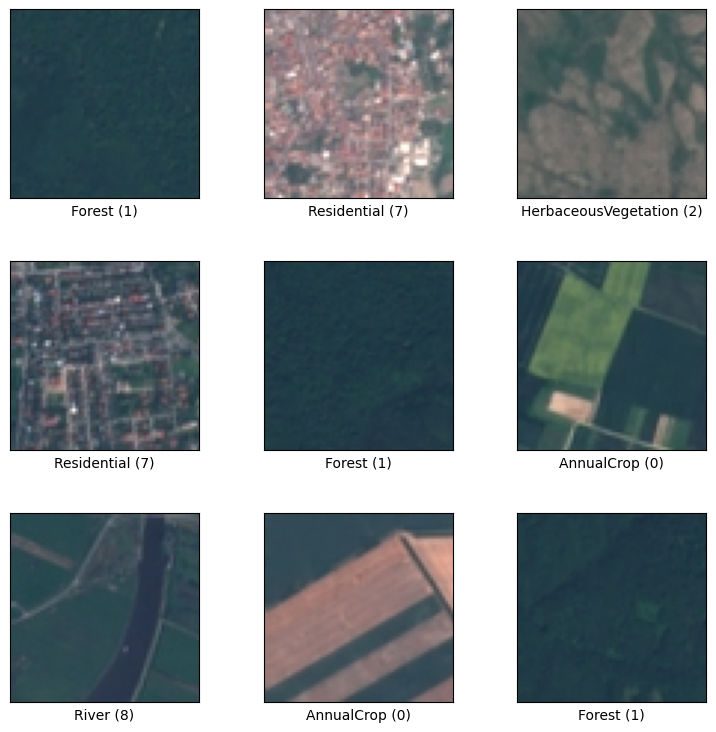

In [7]:
fig = tfds.show_examples(data, metadata)

In [34]:
import seaborn as sns
from matplotlib.gridspec import GridSpec
def show_image_by_channel(image, show_dist:bool = False):
    channels = {
        'red': image[:,:,0],
        'green':image[:,:,1],
        'blue':image[:,:,2],
    }
    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[1, 1])
    ax_kde = fig.add_subplot(gs[1, :])
    # Plot images in the top row
    for i, channel in enumerate(channels):
        ax_img = fig.add_subplot(gs[0, i])
        ax_img.imshow(channels[channel], cmap=channel.capitalize()+"s")
        ax_img.set_title(f'{channel.capitalize()} Channel')
        ax_img.axis('off')

        channel_data = channels[channel].numpy().ravel()
        sns.kdeplot(channel_data, color=channel, ax=ax_kde)

        if show_dist:
            ax_kde.set_title('Pixel Density by Channel')
            ax_kde.set_xlabel('Pixel Value')
            ax_kde.set_ylabel('Density')
            ax_kde.legend([f'{channel.capitalize()} Channel' for channel in channels])
            ax_kde.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()

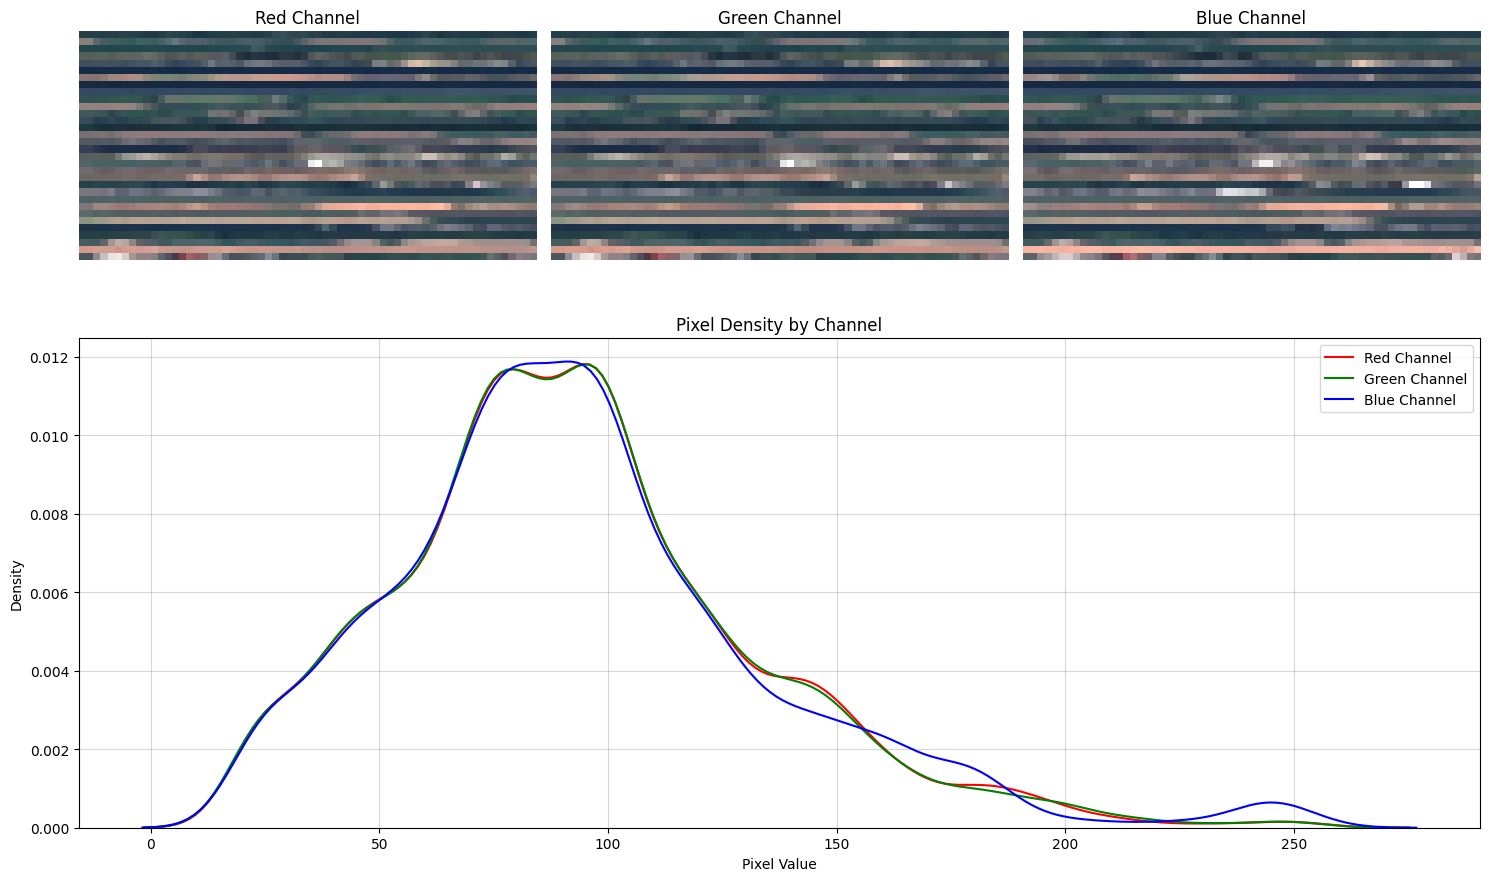

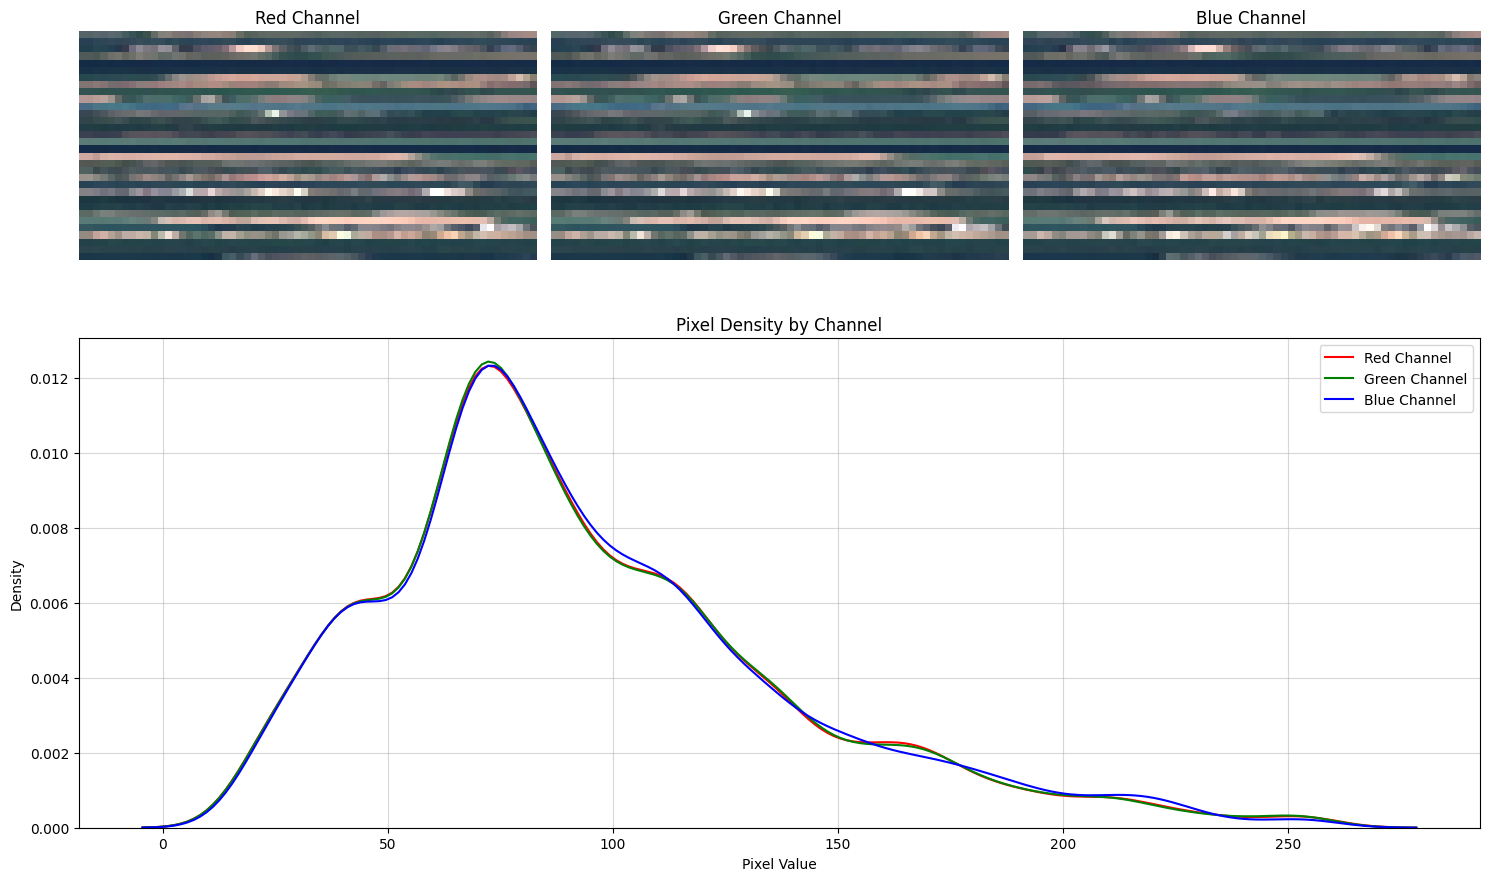

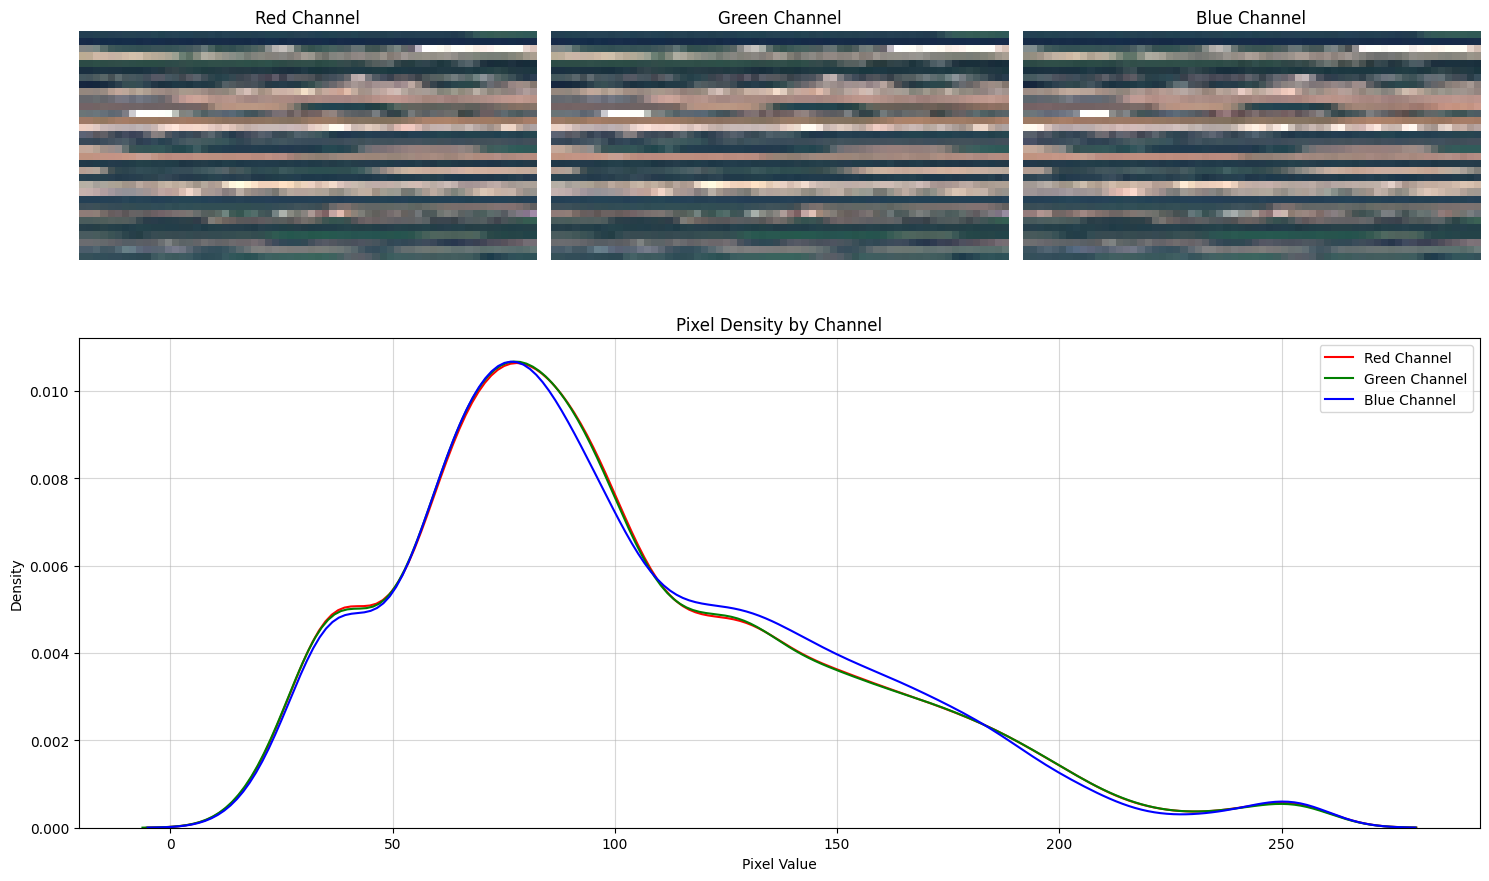

In [35]:
for i, image in enumerate(train.take(3)):
    show_image_by_channel(image[0], show_dist = True)

In [10]:
def get_label_distribution(dataset, metadata, show_plot: bool = True):
  # Convert the dataset to NumPy arrays
  labels = np.array([label for _, label in tfds.as_numpy(dataset)])
  # Get the unique labels and their counts
  unique_labels, label_counts = np.unique(labels, return_counts=True)
  label_names = [metadata.features['label'].int2str(label) for label in unique_labels]
  if show_plot:
    # Plot the label distribution
    plt.figure(figsize=(12, 6))
    plt.bar(label_names, label_counts)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Distribution of Labels in EuroSAT Dataset')
    plt.xticks(rotation=45)
    plt.show()
  return dict(zip(label_names, label_counts))

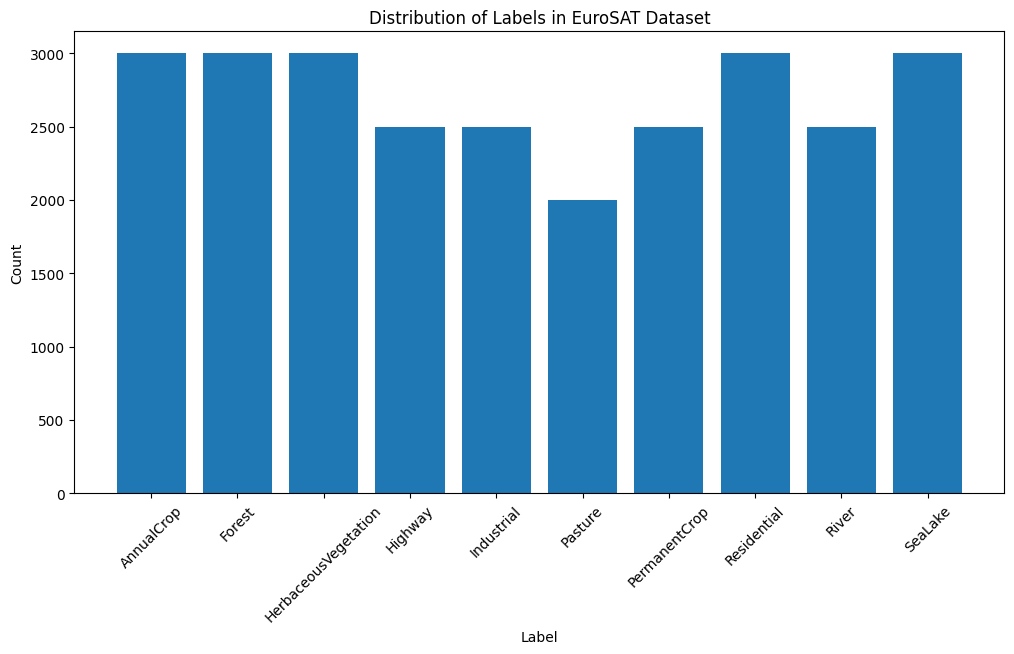

In [11]:
label_dist = get_label_distribution(data, metadata)

In [12]:
label_weights = {label: full_size / (num_labels * count) for label, count in label_dist.items()}
print(label_weights)

{'AnnualCrop': 0.9, 'Forest': 0.9, 'HerbaceousVegetation': 0.9, 'Highway': 1.08, 'Industrial': 1.08, 'Pasture': 1.35, 'PermanentCrop': 1.08, 'Residential': 0.9, 'River': 1.08, 'SeaLake': 0.9}


### Data Preparation

In order to prepare the data to enter the model there are a few things we'll need to do, normalization (which will happen as a part of model building) we''ll also need to batch the data (here i'll chose 32 as the batch size)

In [13]:
# Set batch size (maybe adjust this as part of analysis? )

# Set up caching to optimize model runs
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE).batch(32)
test = test.cache().prefetch(buffer_size=AUTOTUNE).batch(32)

In [14]:
# noramlization
def normalize():
  return layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS))

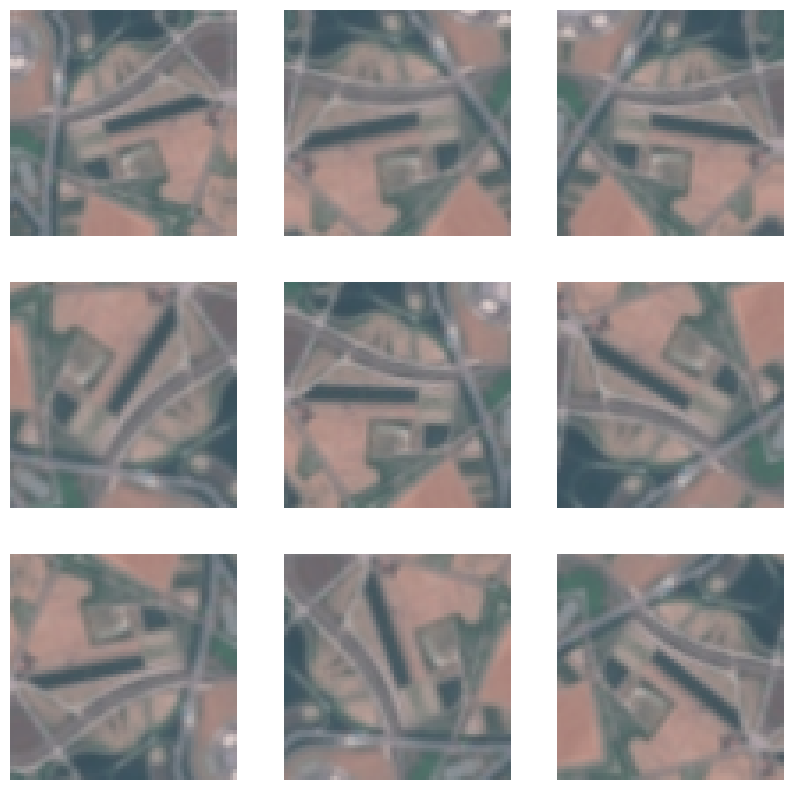

In [121]:
def get_augmentation_layers():
  return keras.Sequential([
      layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT,IMG_WIDTH, NUM_CHANNELS)),
      layers.RandomRotation(0.4),
      layers.RandomZoom(0.1),
    ]
  )




plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
  for i in range(9):
    augmentation = get_augmentation_layers()
    augmented_images = augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model Architecture

For this section i'll be building the model architecture. I've decided to use a commonly used structure, with two layers of convlution followed b y a layer of max pooling. I'm keepign the model relatively simple, so i'll do three iterations of that before adding a fully connected/dense layer and outputing the data.

However, I'll be building three different models with this structure. First I'll have the structure as normal. The next model I'll add dropout and the following model i'll add in some code to try and augment the data a little before entering it into the model to ensure we have enough variety in ourdatasets. Finally we can compare the models afterwards.

In [125]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from typing import Optional
import visualkeras

def build_model(augment: bool, dropout: Optional[int]):
  layers_list = [normalize()]

  if augment:
    layers_list.append(get_augmentation_layers())

  layers_list.extend([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
  ])

  if dropout:
    layers_list.append(layers.Dropout(dropout))

  layers_list.extend([
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels)
  ])
  print(len(layers_list))
  return Sequential(layers_list)

def build_and_fit_model(augment: bool = False, dropout: Optional[float] = None, epochs: int = 5):
  early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)
  model = build_model(augment, dropout)
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  display(visualkeras.layered_view(model))
  model.summary()

  history = model.fit(
    train,
    validation_data=test,
    epochs=epochs,
    callbacks = [early_stop]
  )

  return model, history

In [126]:
TRAIN_EPOCHS = 1

### Model One: Baseline

13


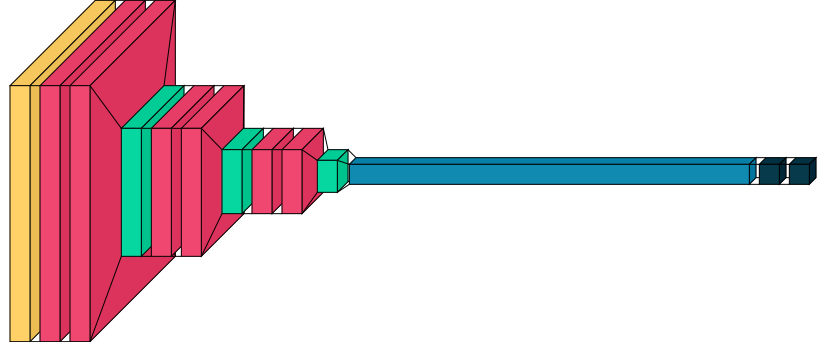

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_60 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 conv2d_61 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_63 (Conv2D)          (None, 32, 32, 32)        9248      
                                                      

In [80]:
model_one, hist_one =  build_and_fit_model(epochs=TRAIN_EPOCHS)

### Model Two: With Dropout

14


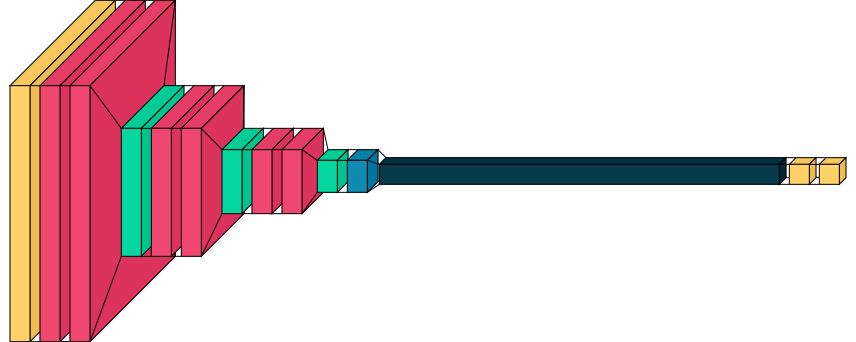

In [74]:
model_two, hist_two = build_and_fit_model(dropout = 0.2, epochs=TRAIN_EPOCHS)

### Model Three: Augmented Input Images

14


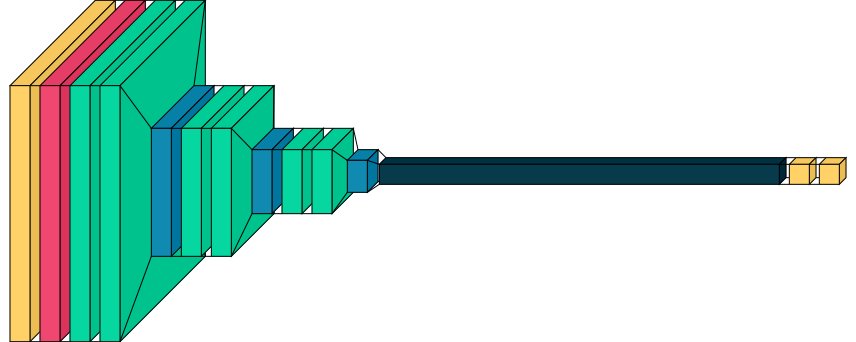

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 sequential_47 (Sequential)  (None, 64, 64, 3)         0         
                                                                 
 conv2d_66 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 conv2d_67 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 32, 32, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 32)        4640      
                                                     

KeyboardInterrupt: 

In [127]:
model_three, hist_three = build_and_fit_model(augment = True, epochs=TRAIN_EPOCHS)

## Results & Analysis

In [94]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_predictions(model, test_data):
  print("Classification Report")
  predictions = model.predict(test_data)
  y_true = np.concatenate([label for _, label in tfds.as_numpy(test_data)])
  y_pred = np.argmax(predictions, axis=1)
  print(classification_report(y_true, y_pred))
  return y_true, y_pred

def show_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

def plot_model_history(history):
  fig, axs = plt.subplots(1, 2, figsize=(20, 6))

  axs[0].plot(history.history['loss'])
  axs[0].plot(history.history['val_loss'])
  axs[0].set_title('Model Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['Train', 'Validation'], loc='upper right')

  axs[1].plot(history.history['accuracy'])
  axs[1].plot(history.history['val_accuracy'])
  axs[1].set_title('Model Accuracy')
  axs[1].set_ylabel('Accuracy')
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['Train', 'Validation'], loc='lower right')
  plt.show()


def evaluate_results(model, history, test_data):
  print("Summary of Accuracy")
  model.evaluate(test_data)
  labels, predicted = make_predictions(model, test_data)
  show_confusion_matrix(labels, predicted)
  plot_model_history(history)


Summary of Accuracy
169/169 [==============================] - 14s 85ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       573
           1       0.77      0.99      0.87       575
           2       0.67      0.70      0.69       621
           3       0.64      0.55      0.59       504
           4       0.93      0.82      0.87       501
           5       0.82      0.63      0.72       397
           6       0.67      0.50      0.57       504
           7       0.78      0.99      0.87       608
           8       0.70      0.68      0.69       511
           9       0.97      0.94      0.96       606

    accuracy                           0.78      5400
   macro avg       0.78      0.77      0.77      5400
weighted avg       0.78      0.78      0.77      5400




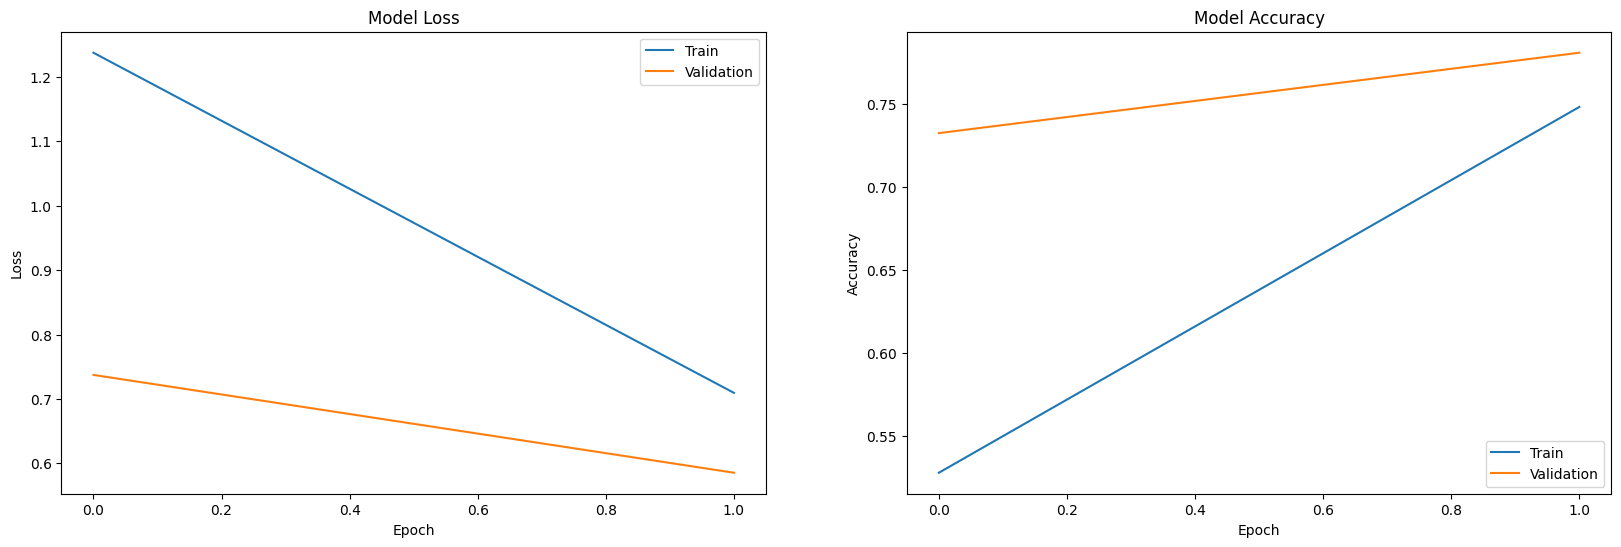

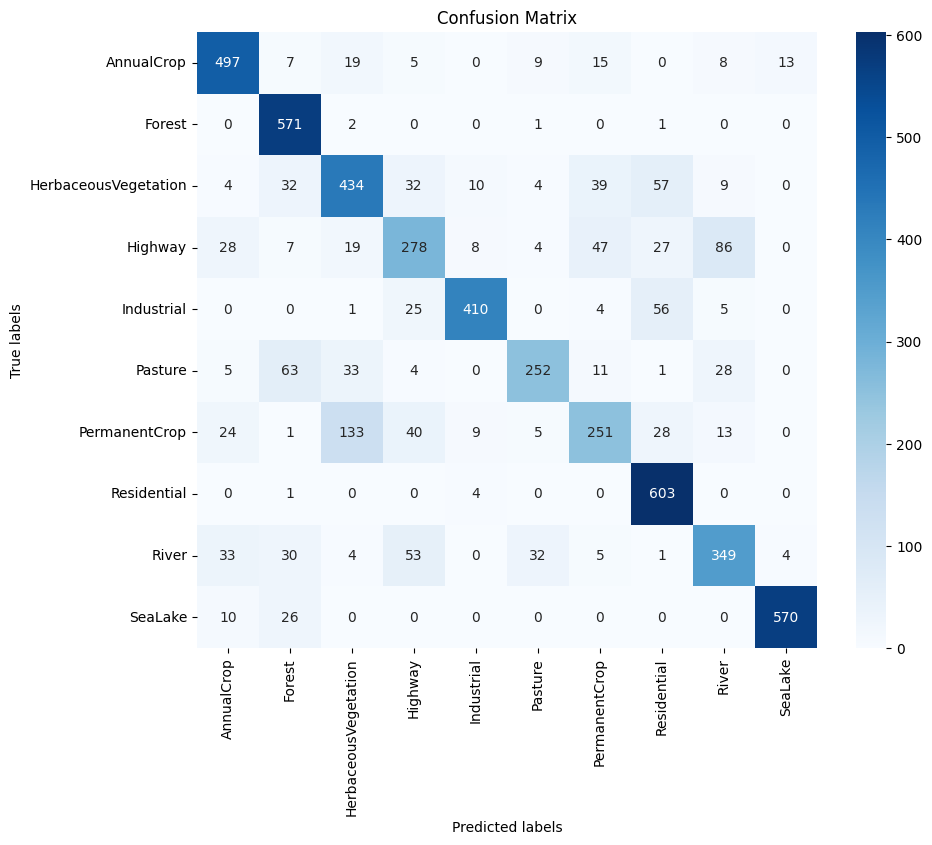

In [95]:
evaluate_results(model_one, hist_one, test)

In [ ]:
evaluate_results(model_two, hist_two, test)

In [ ]:
evaluate_results(model_three, hist_three, test)

In [108]:
predictions = model_one.predict(test)


169/169 [==============================] - 15s 91ms/step


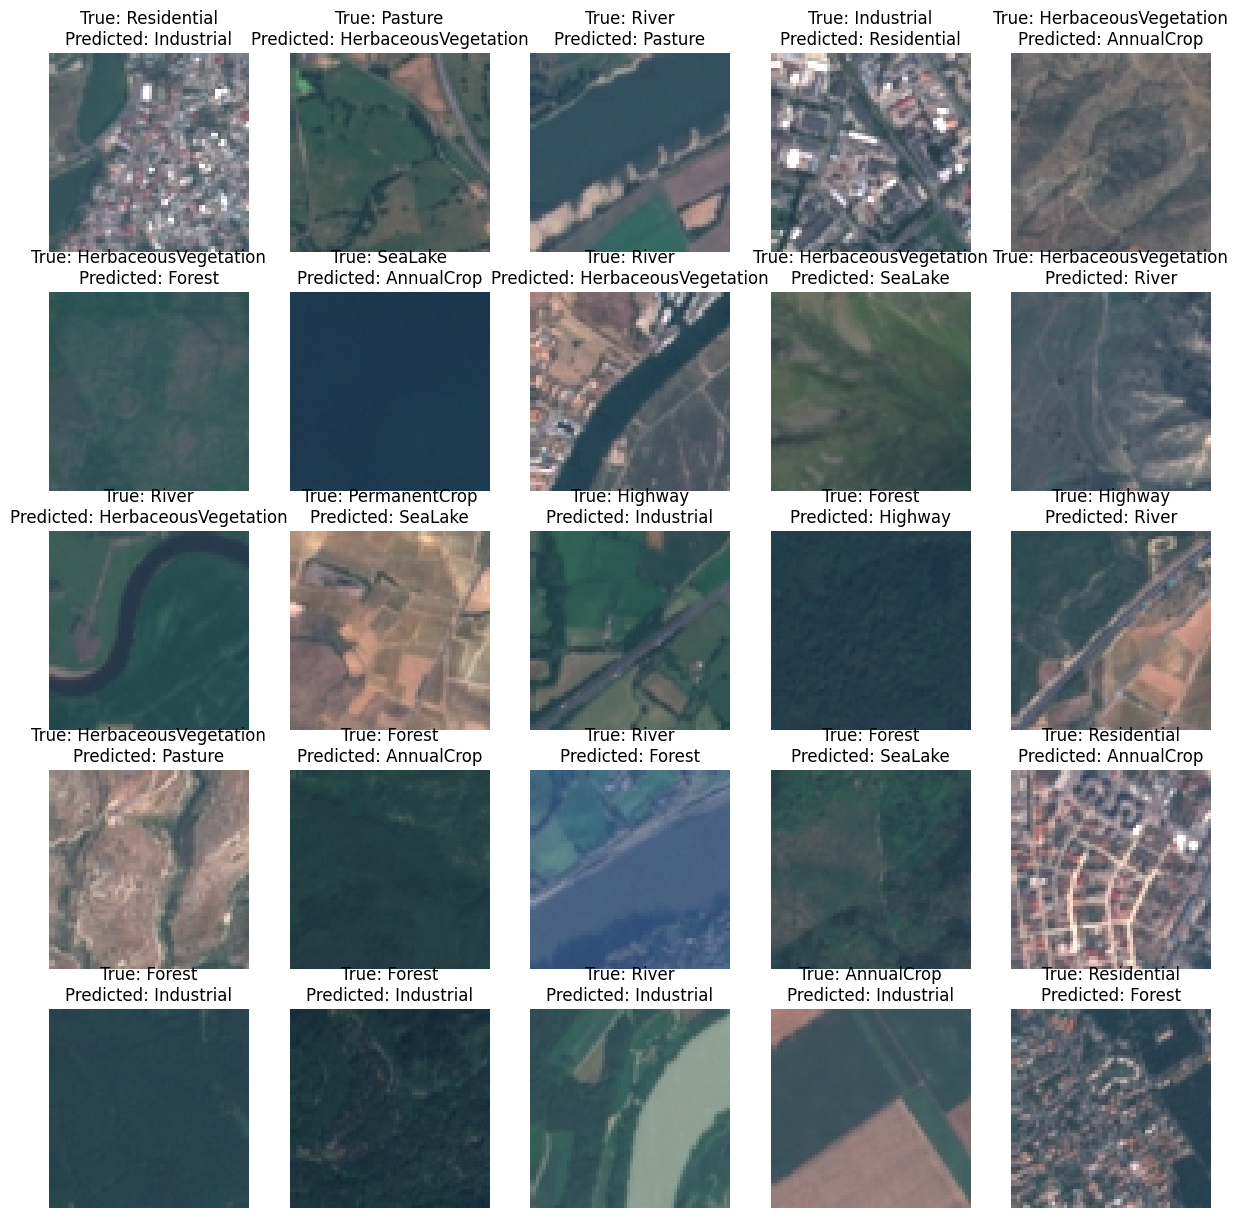

In [116]:
import matplotlib.pyplot as plt

# Define a function to show images with labels
def show_images(dataset, metadata, predictions=None):
    # Grab one batch of images
    images, labels = next(iter(tfds.as_numpy(dataset.take(1))))
    # Create a figure to hold the plots
    plt.figure(figsize=(15, 15))
    # Iterate through the images in the batch
    for i, (image, label) in enumerate(zip(images, labels)):
        # Ensure image is in the correct shape
        image = image.reshape((64, 64, 3))

        # Plot the image
        plt.subplot(5, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')

        # Add the label if available
        if metadata is not None:
            label_name = metadata.features['label'].int2str(label)
            if predictions is not None:
                predicted_label = metadata.features['label'].int2str(np.argmax(predictions[i]))
                plt.title(f'Original: {label_name}\nPredicted: {predicted_label}')
            else:
                plt.title(f'Label: {label_name}')

        # Show only 25 images
        if i == 24:
            break

    plt.tight_layout()
    plt.show()


def show_incorrect_classifications(dataset,  metadata, predictions):
  plt.figure(figsize=(15, 15))
  num_images = 0
  for images, labels in tfds.as_numpy(dataset):
    for i, image in enumerate(images):
      p = np.argmax(predictions[i])
      if p != labels[i]:
        image = image.reshape((64, 64, 3))
        plt.subplot(5, 5, num_images + 1)
        plt.imshow(image)
        plt.axis('off')
        label_name = metadata.features['label'].int2str(labels[i])
        predicted_name = metadata.features['label'].int2str(p)
        plt.title(f'True: {label_name}\nPredicted: {predicted_name}')
        num_images += 1
      if num_images == 25:
        return
  plt.tight_layout()
  plt.show()


show_incorrect_classifications(test, metadata, predictions)


## Conclusions